DATA SET HANDLING

In [6]:
from google.colab import files
import zipfile

uploaded = files.upload()  # Upload ZIP
zip_path = list(uploaded.keys())[0]
extract_path = "/content/garbage_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Path to extracted dataset
dataset_dir = extract_path

Saving kaggle_garbage_dataset.zip to kaggle_garbage_dataset.zip


INITIAL SETUP


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

image_size = (124, 124)
batch_size = 32
seed = 42

LOAD DATASETS

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

val_class = val_ds.class_names
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 2545 files belonging to 2 classes.
Using 2036 files for training.
Found 2545 files belonging to 2 classes.
Using 509 files for validation.


EXPLORE DATA

['TrashType_Image_Dataset', 'garbage']
['TrashType_Image_Dataset', 'garbage']
2


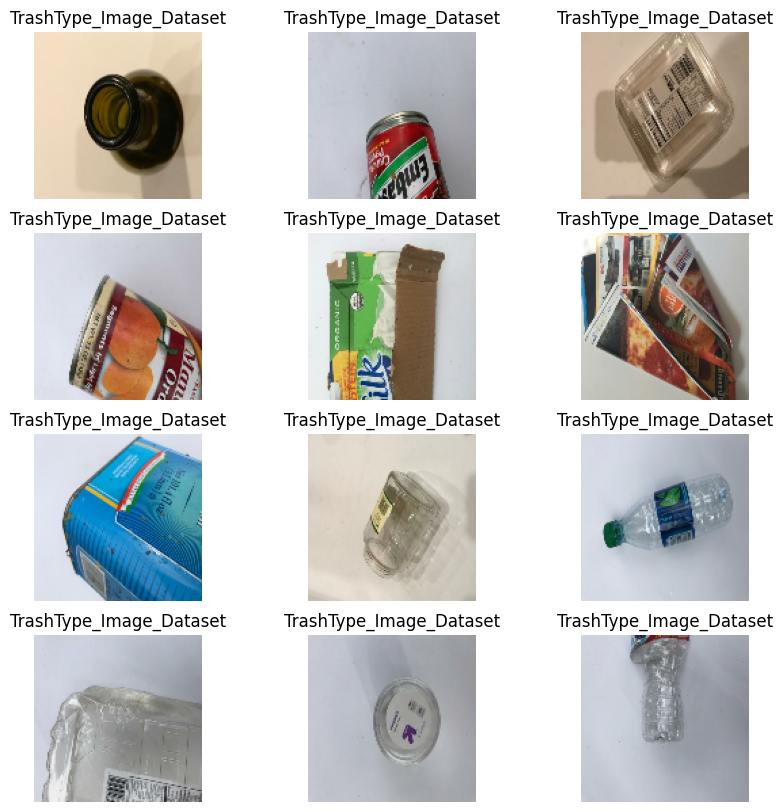

In [9]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

CLASS DISTRIBUTION

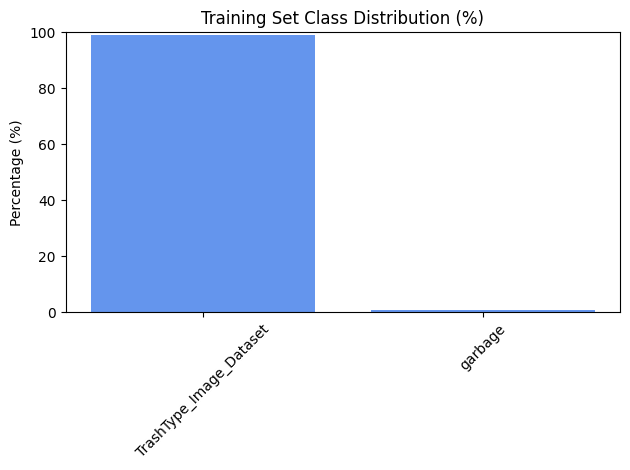

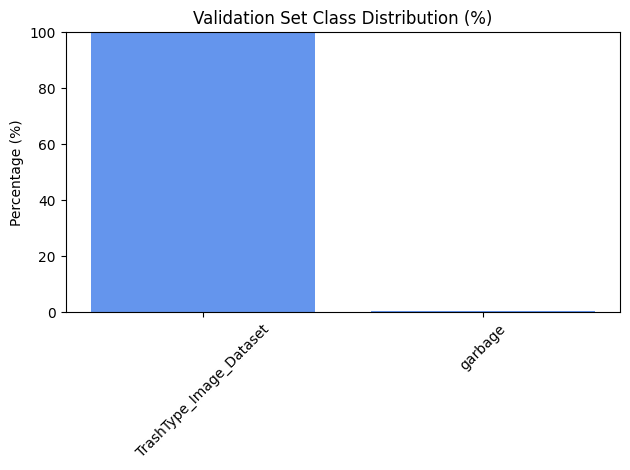

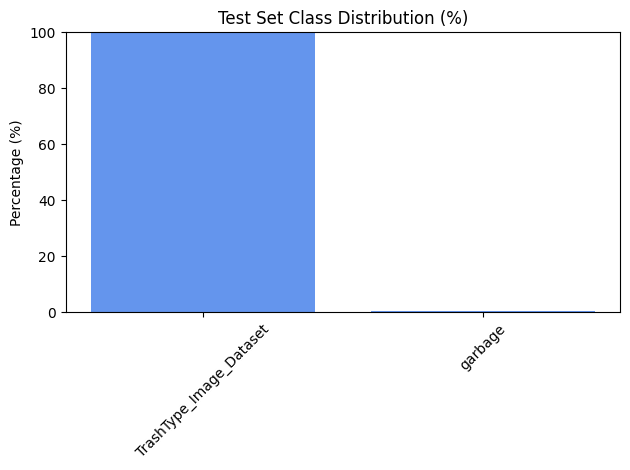

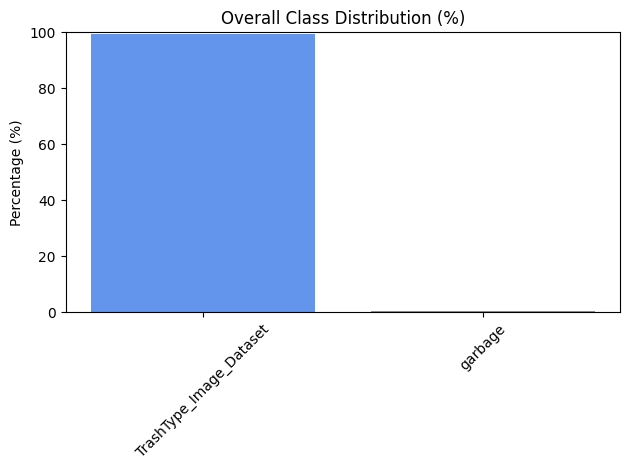

In [10]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        for label in labels.numpy():
            counts[class_names[label]] += 1
            total += 1
    if total == 0:
        return {name: 0 for name in class_names} # Return 0% for all classes if dataset is empty
    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)
    return counts

def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

class_names = train_ds.class_names
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {k: round((train_dist[k] + val_dist[k]) / 2, 2) for k in class_names}

simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

CLASS WEIGHTS

In [11]:
all_labels = []
class_counts = {i: 0 for i in range(len(class_names))}

for _, labels in train_ds:
    for label in labels.numpy():
        all_labels.append(label)
        class_counts[label] += 1

class_weights_array = compute_class_weight('balanced', classes=np.arange(len(class_names)), y=all_labels)
class_weights = {i: w for i, w in enumerate(class_weights_array)}

MODEL BUILDING

In [12]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(124, 124, 3),
    include_preprocessing=True,
    weights='imagenet'
)

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


TRAINING

In [13]:
early = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.5191 - loss: 0.7668 - val_accuracy: 0.6582 - val_loss: 0.6061
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.6385 - loss: 0.5684 - val_accuracy: 0.6601 - val_loss: 0.6282
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.6491 - loss: 0.4845 - val_accuracy: 0.7230 - val_loss: 0.5608
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.7168 - loss: 0.3651 - val_accuracy: 0.7682 - val_loss: 0.4971
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.7868 - loss: 0.3440 - val_accuracy: 0.8055 - val_loss: 0.4410
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.8283 - loss: 0.3509 - val_accuracy: 0.8527 - val_loss: 0.3781
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.8573 - loss: 0.3583 - val_accuracy: 0.8762 - val_loss: 0.3329
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.8552 - loss: 0.2210 - val_accuracy: 0.9136 - v

EVALUATION

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 762ms/step - accuracy: 0.9733 - loss: 0.1364
Test Accuracy: 0.96875


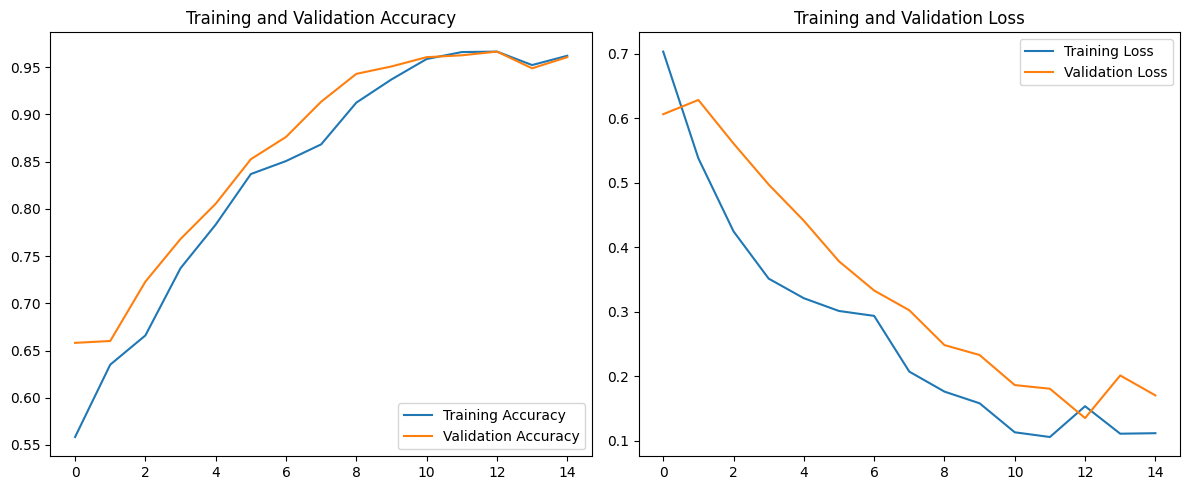

In [14]:
loss, acc = model.evaluate(test_ds_eval)
print("Test Accuracy:", acc)

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.show()

plot_history(history)

CONFUSION MATRIX

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


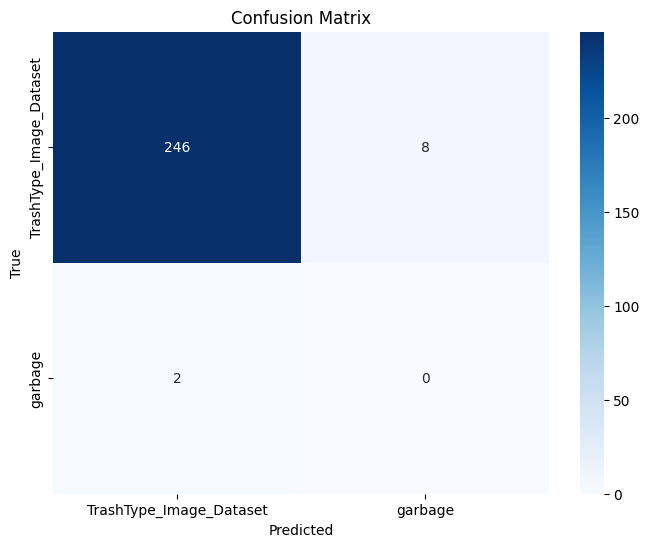

                         precision    recall  f1-score   support

TrashType_Image_Dataset       0.99      0.97      0.98       254
                garbage       0.00      0.00      0.00         2

               accuracy                           0.96       256
              macro avg       0.50      0.48      0.49       256
           weighted avg       0.98      0.96      0.97       256



In [15]:
true_labels = []
pred_labels = []
for images, labels in test_ds:
    preds = model.predict(images)
    true_labels.extend(labels.numpy())
    pred_labels.extend(np.argmax(preds, axis=1))

conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

GRADIO APP

In [16]:

def predict_image(img):
    img = img.resize((124, 124))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    return class_names[np.argmax(pred)]

interface = gr.Interface(fn=predict_image,
                         inputs=gr.Image(type="pil"),
                         outputs="text",
                         title="Garbage Classification",
                         description="Upload a garbage image to classify it.")
interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0c844a765ef14294c4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
